### Desafío - Regularización

**nombre alumno: Juan Oyarce G

Profesor: Gabriel Tamayo L.

Generación: GX

Para realizar este desafío debes haber revisado la lectura y videos correspondiente a la unidad.
Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y csv).
Una vez terminado el desafío, comprime la carpeta y sube el .zip a la sección
correspondiente.


#### Descripción
En esta ocasión utilizaremos datos de la composición química de muestras de vino.

Nuestro propósito será tratar de predecir su calidad a partir de su composición química.

Comience su estudio realizando un breve análisis exploratorio y descriptivo:
* Identifique el tipo de datos de cada columna.
* Identifique outliers univariados y multivariados. Los primeros los puede encontrar realizando boxplots de cada atributo, los segundos estudiando los scatterplot entre pares de atributos.
* Encuentre la cantidad de valores faltantes en cada columna.
* Grafique la distribución empírica de cada atributo.

### Ejercicio 1: Preparación del Ambiente de Trabajo
* Importe las librerías básicas
* Importe los métodos asociados a regularización
* Importe la base de datos

In [67]:
# Importación de librerías 

# importación de las librerías tradicionales de pandas, numpys, statsmodels, scipy, seaborn y matplotlib
import numpy as np
import pandas as pd
pd.options.display.max_columns = None #instrucción para que muestre todas las columnas del dataframe sin abreviarlas
pd.options.display.max_rows = 100 #instrucción para que muestre  n  las filas del dataframe sin abreviarlas
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import factor_analyzer as factor
import missingno as msngo
import warnings
warnings.filterwarnings("ignore")



# Librerías de sklearn 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# metodos de regularización

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
import cv_error as gfx


# Gráficos estilo seaborn
plt.style.use('seaborn')

# plt.rcParams["figure.figsize"] = (6, 3) # Tamaño gráficos
# plt.rcParams["figure.dpi"] = 200 # resolución gráficos

In [2]:
df= pd.read_csv('winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Ejercicio 2: Análisis exploratorio
* Identifique el tipo de datos de cada columna.
* Identifique outliers univariados y multivariados. Los primeros los puede encontrar realizando boxplots de cada atributo, los segundos estudiando los scatterplot entre pares de atributos.

In [3]:
df.shape

(1599, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
#Outlier univariados

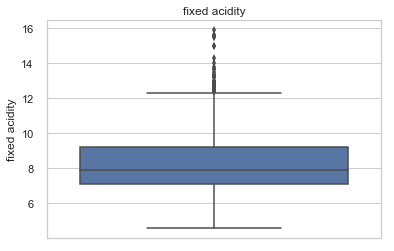

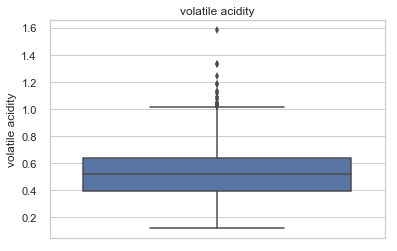

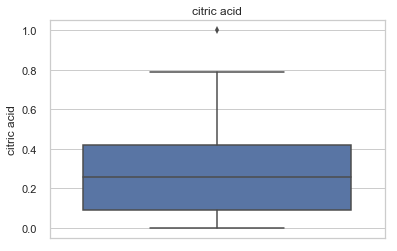

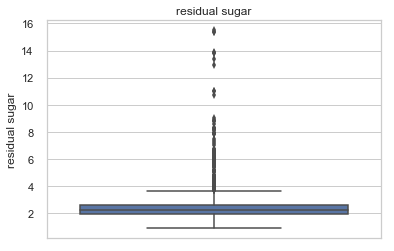

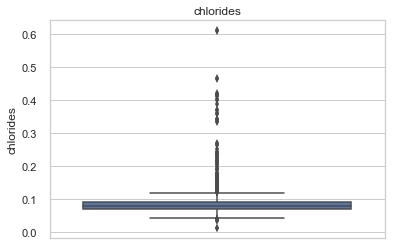

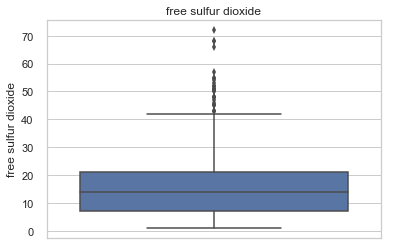

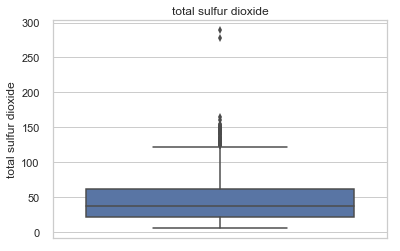

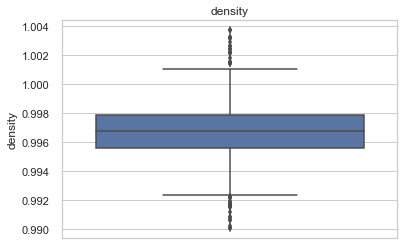

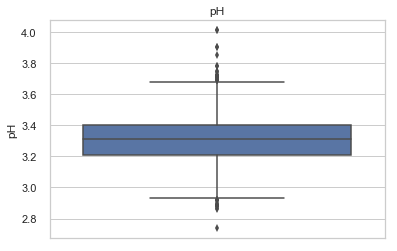

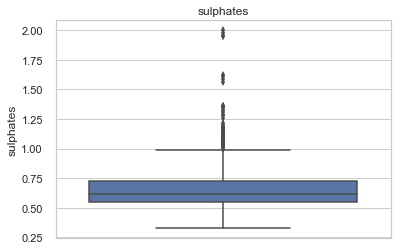

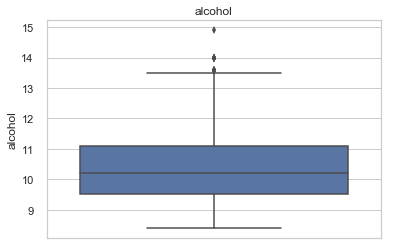

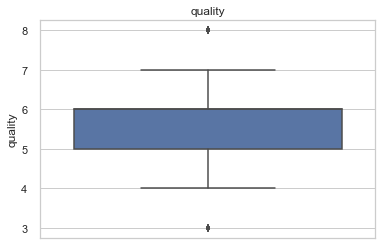

In [6]:
for i in df.columns:
    plt.figure()
    sns.set(style="whitegrid")
    sns.boxplot(y=df[i])
    plt.title(i)

- Los boxplots demuestra que la mayoría de las variables presenta una distribución cercana a valores medios o en el extremo inferior de las distribuciones, se aprecia la existencia de outliers hacia valores extremos, especialmente superiores, como en variables como sugar residual o clorides, por ejemplo, sin embargo debido al número suficiente de registros, no se cree que sea necesario eliminar estos outliers o generar un tratamiento adicional.

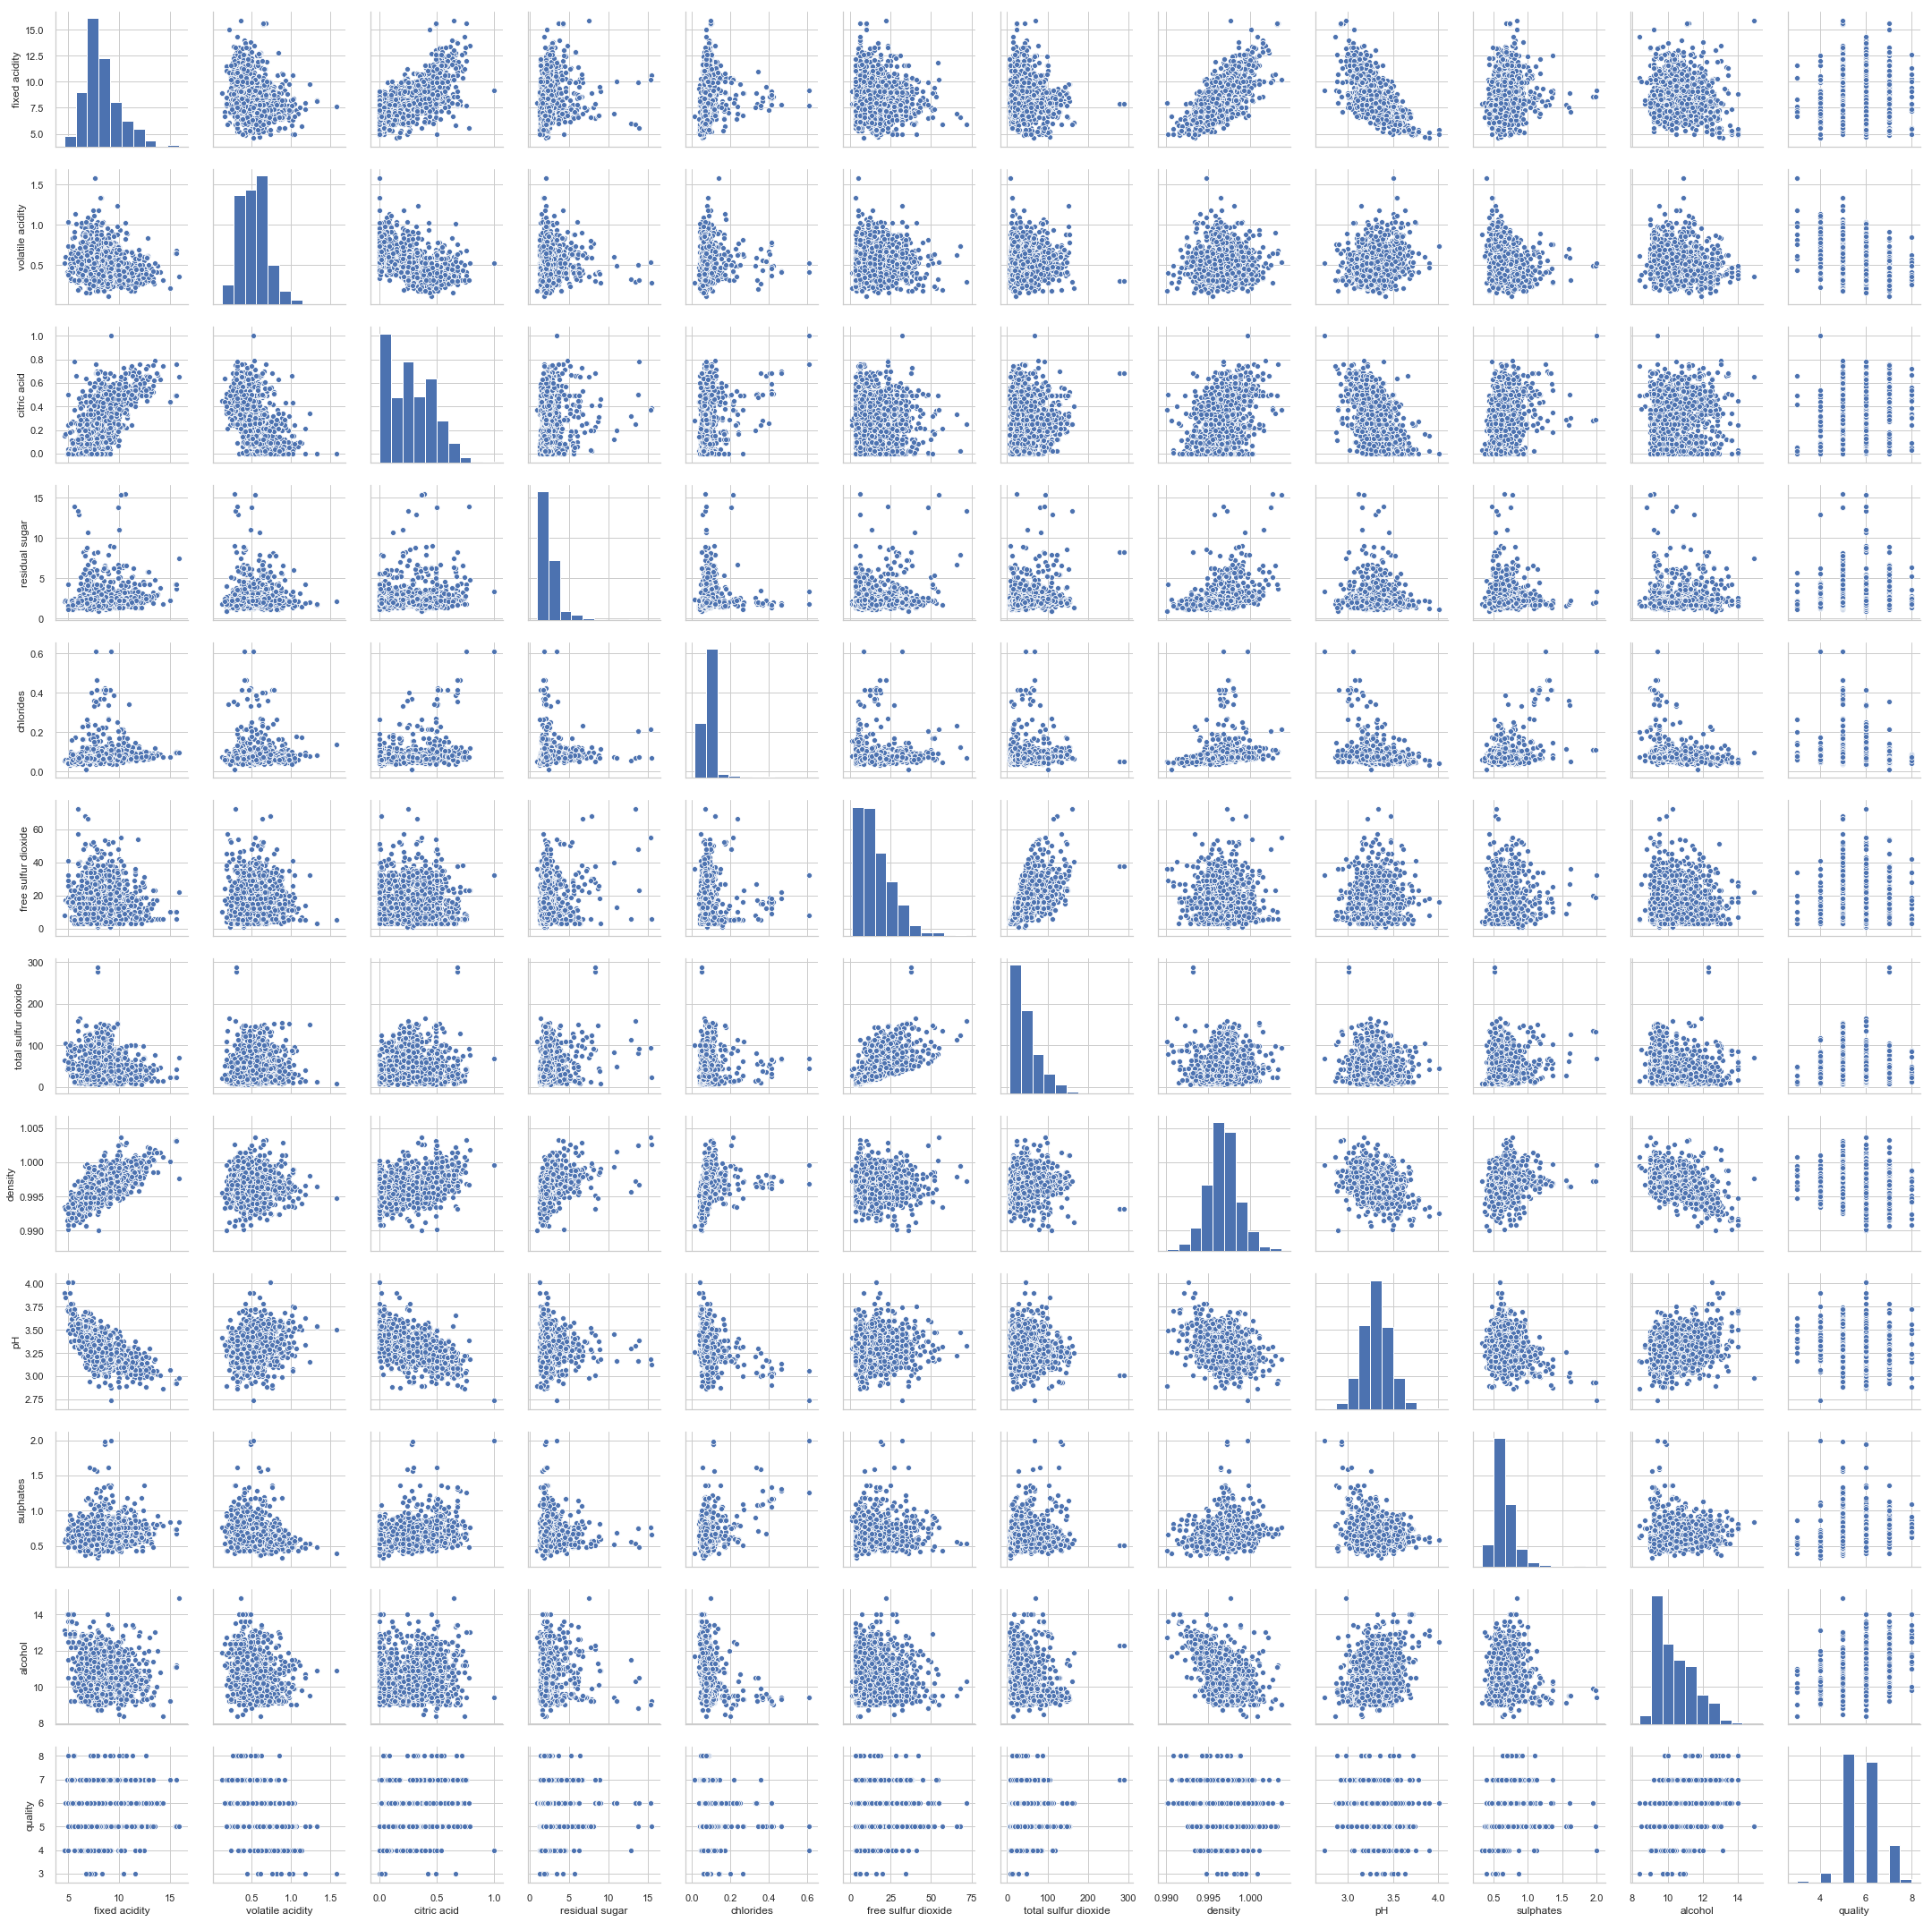

In [7]:
#Outlier multivariados


sns.pairplot(df)



In [9]:
# correlaciones para observar si existe colinealidad entre los datos de la muestra

df.corr().style.background_gradient() 

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1,-0.256131,0.671703,0.114777,0.0937052,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.0616683,0.124052
volatile acidity,-0.256131,1,-0.552496,0.00191788,0.0612978,-0.0105038,0.07647,0.0220262,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1,0.143577,0.203823,-0.0609781,0.035533,0.364947,-0.541904,0.31277,0.109903,0.226373
residual sugar,0.114777,0.00191788,0.143577,1,0.0556095,0.187049,0.203028,0.355283,-0.0856524,0.00552712,0.0420754,0.0137316
chlorides,0.0937052,0.0612978,0.203823,0.0556095,1,0.00556215,0.0474005,0.200632,-0.265026,0.37126,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.0105038,-0.0609781,0.187049,0.00556215,1,0.667666,-0.0219458,0.0703775,0.0516576,-0.0694084,-0.0506561
total sulfur dioxide,-0.113181,0.07647,0.035533,0.203028,0.0474005,0.667666,1,0.0712695,-0.0664946,0.0429468,-0.205654,-0.1851
density,0.668047,0.0220262,0.364947,0.355283,0.200632,-0.0219458,0.0712695,1,-0.341699,0.148506,-0.49618,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.0856524,-0.265026,0.0703775,-0.0664946,-0.341699,1,-0.196648,0.205633,-0.0577314
sulphates,0.183006,-0.260987,0.31277,0.00552712,0.37126,0.0516576,0.0429468,0.148506,-0.196648,1,0.0935948,0.251397


In [11]:
df.rename(columns=lambda x: x.replace('fixed acidity', 'fixed_acidity'), inplace=True) #  renombrar

In [12]:
df.rename(columns=lambda x: x.replace('citric acid', 'citric_acid'), inplace=True) #  renombrar


- En general se aprecia en el scatter plot y en el heatmap de correlaciones que existen correlaciones parciales entre las variables, que no son demasiado fuertes, por lo que se descarta una posible colinealidad, pero para ser más rigurosos se determinará con el test VIF (Factor de inflación de la Varianza) que permite examinar si un par de variables presenta colinealidad. 

In [13]:
# VIF FACTOR DE INFLACION DE LA VARIANZA ... MULTICOLINEALIDAD (R2 DE 0.8 hacia arriba alta colinealidad)

lm_n = smf.ols('fixed_acidity ~ density + citric_acid', data=df).fit() #todas las columnas deben ser  renombradas sin espacios, sino no son reconocidas por el modelo smf
rsquared_n= lm_n.rsquared
vif = (1/(1-rsquared_n)).round(3)

if vif == 1:
    print(vif, 'Las variables no están correlacionadas')
elif vif <5:
    print(vif,'Las variables están correlacionadas parcialmente y podrían quedarse en el modelo')
else:
    print(vif,'las variables están altamente correlacionadas y deben salir del modelo')


2.92 Las variables están correlacionadas parcialmente y podrían quedarse en el modelo


- La interpretación del VIF es que si es mayor a 5 existe colinealidad entre las variables y debe salir alguna del modelo, un VIF mayor a 5 equivale a un r2 superior a 0.8, para el caso de las variables de éste dataset no se presenta colinealidad.

In [14]:
df.corr()[['quality']].sort_values(by = 'quality',ascending = False)\
.style.background_gradient()

,quality
quality,1
alcohol,0.476166
sulphates,0.251397
citric_acid,0.226373
fixed_acidity,0.124052
residual sugar,0.0137316
free sulfur dioxide,-0.0506561
pH,-0.0577314
chlorides,-0.128907
density,-0.174919


<Figure size 432x432 with 0 Axes>

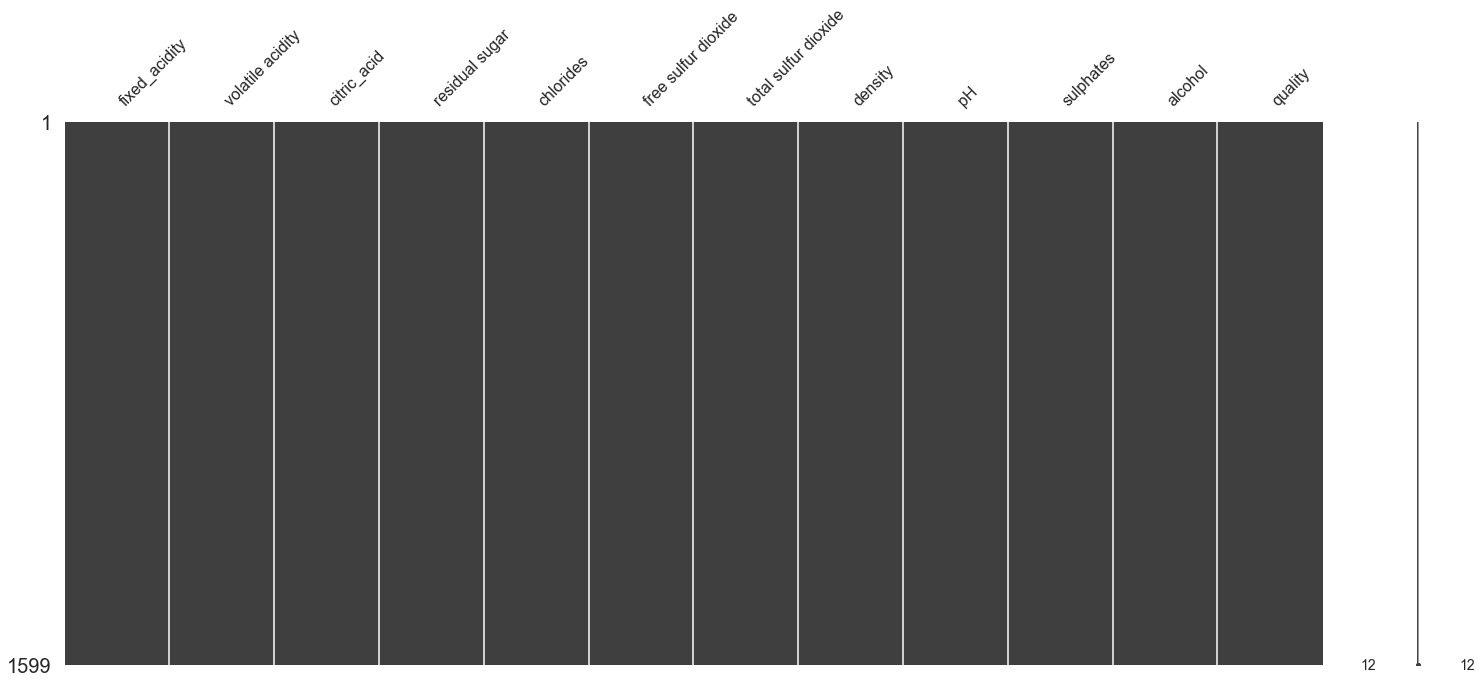

In [15]:
#valores perdidos

plt.figure(figsize=(6,6))
msngo.matrix(df);

In [16]:
def test_normal_distribution(dataframe, var):
    sns.distplot(dataframe[var], fit = norm);
    plt.figure()
    stats.probplot(dataframe[var], plot = plt)
    plt.figure()
    asimetria=dataframe[var].skew().round(3)
    if asimetria >= -0.6 and asimetria<= 0.6:
        print("El Coeficiente de asimetría tiene un valor de: ", asimetria," lo que significa la curva es simétrica y se aproxima a la normal")
    else:
        print("El coeficiente de asimetría es:", asimetria, " y no se ajusta  a una distribución normal")
    curtosis=dataframe[var].kurt().round(3)
    if curtosis >= -0.6 and curtosis<= 0.6:
        print("El Coeficiente de curtosis tiene un valor de: ", curtosis,"lo que significa la curva es mesocurtica y se aproxima a la normal")
    else:
        print("El coeficiente de curtosis es:",curtosis ," y no se ajusta  a una distribución normal")
    
    

fixed_acidity
El coeficiente de asimetría es: 0.983  y no se ajusta  a una distribución normal
El coeficiente de curtosis es: 1.132  y no se ajusta  a una distribución normal


-------------
volatile acidity
El coeficiente de asimetría es: 0.672  y no se ajusta  a una distribución normal
El coeficiente de curtosis es: 1.226  y no se ajusta  a una distribución normal


-------------
citric_acid
El Coeficiente de asimetría tiene un valor de:  0.318  lo que significa la curva es simétrica y se aproxima a la normal
El coeficiente de curtosis es: -0.789  y no se ajusta  a una distribución normal


-------------
residual sugar
El coeficiente de asimetría es: 4.541  y no se ajusta  a una distribución normal
El coeficiente de curtosis es: 28.618  y no se ajusta  a una distribución normal


-------------
chlorides
El coeficiente de asimetría es: 5.68  y no se ajusta  a una distribución normal
El coeficiente de curtosis es: 41.716  y no se ajusta  a una distribución normal


-------------
free s

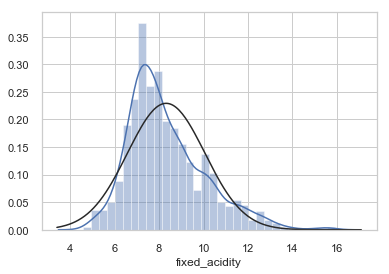

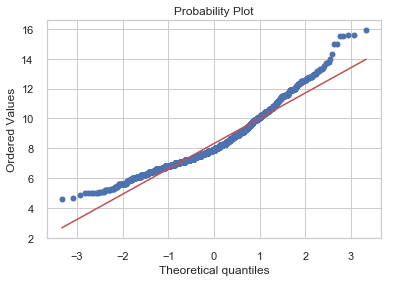

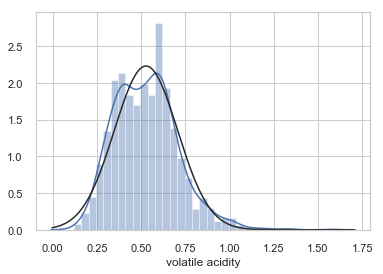

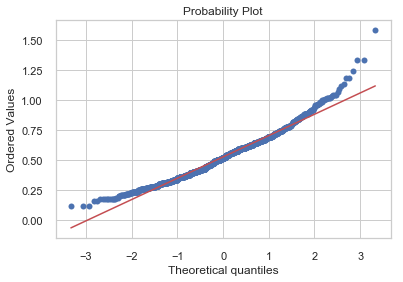

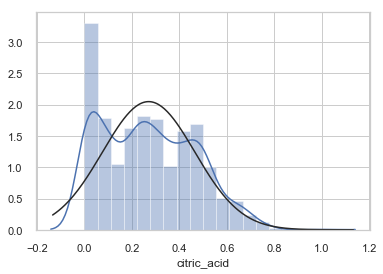

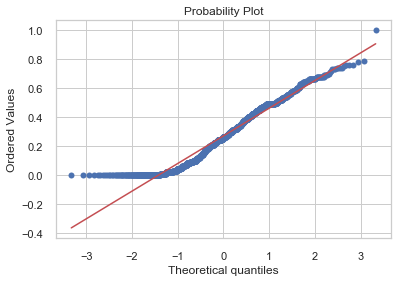

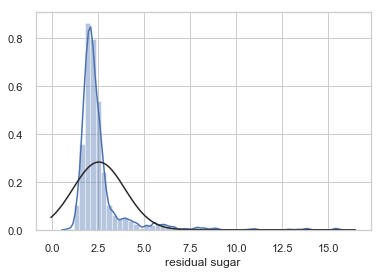

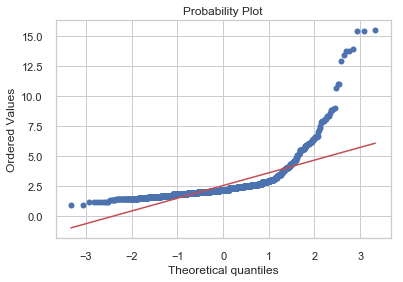

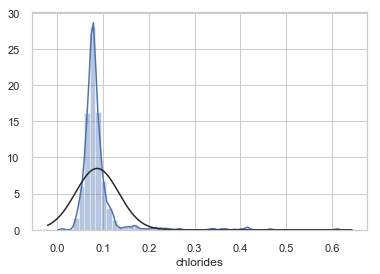

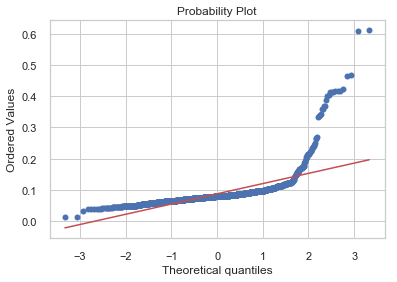

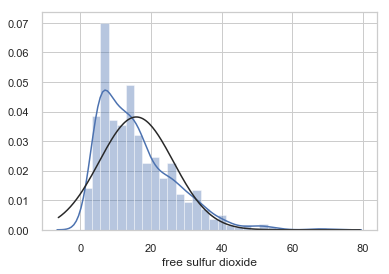

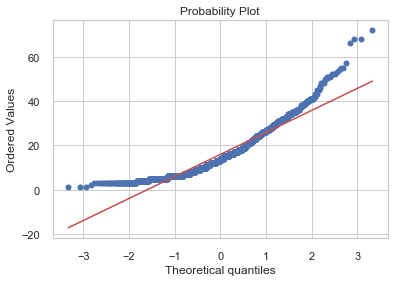

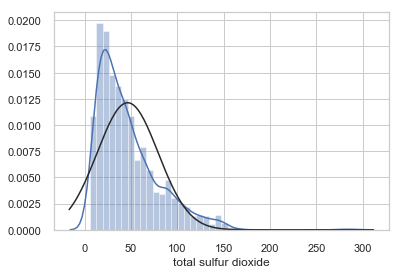

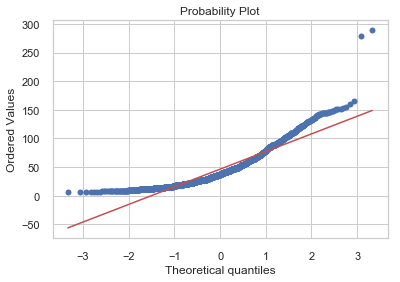

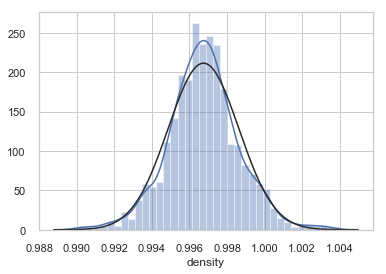

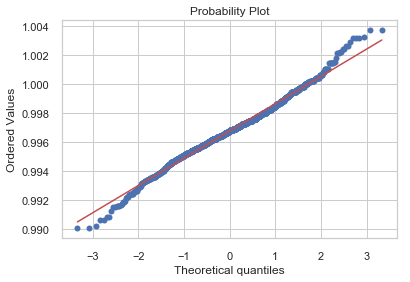

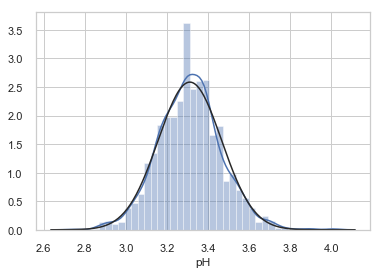

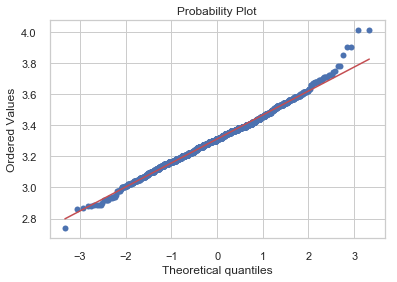

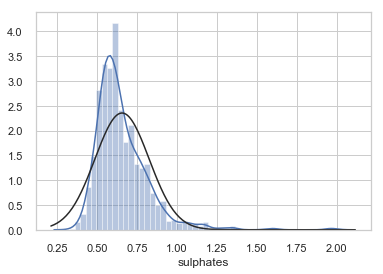

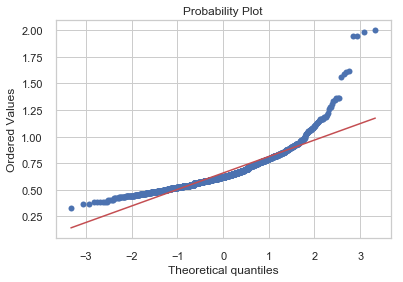

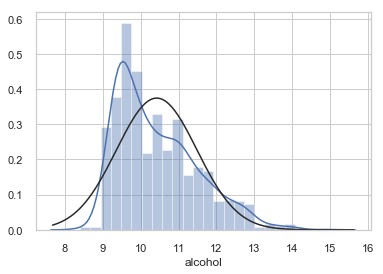

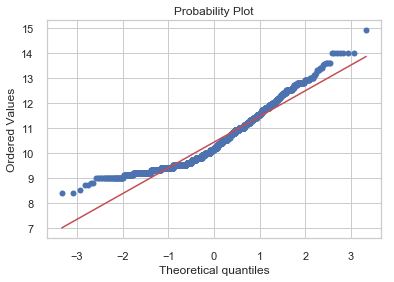

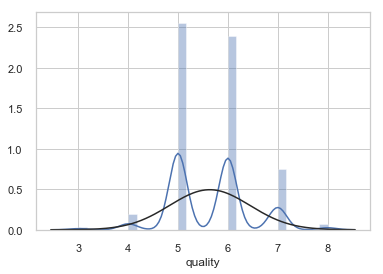

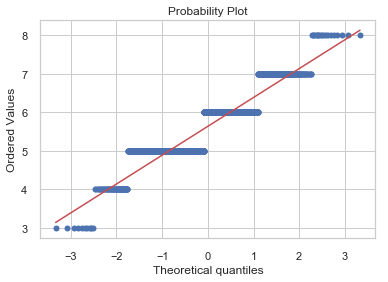

<Figure size 432x288 with 0 Axes>

In [17]:
variables_continuas = df.columns
for i in variables_continuas:
    print(i)
    test_normal_distribution(df,i)
    print('\n')
    print('-------------')

- En las pruebas de normalidad podemos apreciar, que muchas variables no se ajustan bien a la distribución normal, en cambio otras si tienen comportamientos asimilables a ésta distribución. Para el caso específico de quality podemos observar que su comportamiento si puede ser apróximado a una distribución normal, por lo que no aplicaremos transformaciones adicionales.

### Ejercicio 3: Regularización de modelos
Genere tres modelos, correspondientes a RidgeCV , LassoCV y ElasticNetCV . Para cada uno de ellos implemente los siguientes pasos:
* Entrene los modelos con 10 validaciones cruzadas.
* Extraiga los coeficientes estimados, el mejor valor alpha, MAE (median_absolute_error) y RMSE (mean_squared_error) asociado a cada modelo.

En base a la información solicitada, responda lo siguiente:
* ¿Qué modelo presenta un mejor desempeño en base a las métricas?
* ¿Qué atributos mantienen un comportamiento similar a lo largo de cada modelo?

Sobre los métodos RidgeCV , LassoCV y ElasticNetCV
* Para implementar la búsqueda de hiperparámetros con validación cruzada, utilizaremos la clase sklearn.linear_model.{RidgeCV, LassoCV, ElasticNetCV} .
* Por defecto, la clase necesita de una lista de valores alphas que representa el hiperparámetro de validación. Si no se define la lista, el método incorporará un array con valores por defecto.
* Por defecto la clase tendrá una opción scoring que permitirá definir la métrica con la cual se evaluará el mejor hiperparámetro. Para el caso de un problema de regresión, si no se define, la métrica será el error cuadrático promedio negativo (más alto es mejor).
* Una vez entrenado el modelo, se puede reportar el mejor alpha con modelo_entrenado.alpha_ , el valor de los coeficientes con modelo_entrenado.coef_.

In [18]:
df.columns

Index(['fixed_acidity', 'volatile acidity', 'citric_acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [19]:
# escalamiento de las variables 


scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df_scaled['quality'] = np.log(df['quality'])

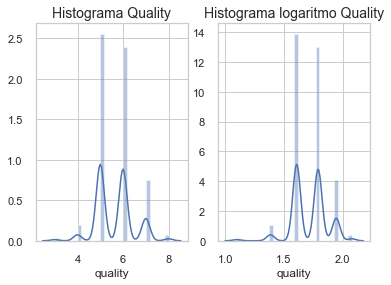

In [20]:
fig , ax = plt.subplots(1,2)
sns.distplot(df['quality'], bins='fd',ax = ax[0])\
.set_title('Histograma Quality', size = 14)
sns.distplot(df_scaled['quality'], bins = 'fd', ax = ax[1])\
.set_title('Histograma logaritmo Quality', size = 14);

In [21]:
# X será nuestro conjunto de atributos. y será nuestra variable objetivo
X = df_scaled.iloc[:,:-1] # Tomamos todas las columnas menos última : fijarse en el Método ILOC

N = X.shape[0] # guardamos el número de filas (datos de entrenamiento)
y = df_scaled['quality'] # asignamos como target la variable 'price'
#Separamos los subsets de test y train
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.33,
random_state = 1986)

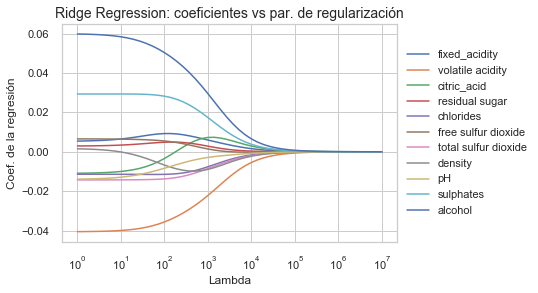

In [22]:
names_regressors = X_train.columns # guardamos los nombres de los atributos
alphas = np.logspace(0, 7, base = 10) # generamos un vector con los valores de la norma

coefs_ridge = [] #lista para guardar parámetros
cv_err_ridge = [] #lista para guardar parámetros
model_ridge = Ridge(fit_intercept = True) # instanciamos el modelo
tol = 0.1 # determinamos el umbral de tolerancia
# para cada valor en el vector
for a in alphas:
    # estimamos el modelo con éste
    model_ridge.set_params(alpha = a)
    model_ridge.fit(X_train, y_train)
    # guardamos el coeficiente estimado
    coefs_ridge.append(model_ridge.coef_)
    # generamos su estimador de validación cruzada
    dummy,cv_err_estimates = gfx.cv_error(X_train, y_train, k = 10, method ='ridge', alpha = a)
    cv_err_ridge.append(np.mean(cv_err_estimates)) # OJO: estamos guardando la media del error de cv para cada alpha
for y_arr, label in zip(np.squeeze(coefs_ridge).T, names_regressors):
    plt.plot(alphas, y_arr, label = label)
    
plt.legend()
plt.xscale("log")
plt.title("Ridge Regression: coeficientes vs par. de regularización", size =14)
plt.xlabel('Lambda')
plt.ylabel('Coef. de la regresión')
plt.axis("tight")
plt.legend(loc="center left", bbox_to_anchor=(1, .5))   
    


In [23]:
def report_regularization(model, X_test, y_test):
    print('Valor del parámetro de regularización: {0}'.format(model.alpha_))
    print('Coeficientes finales: \n{0}'.format(model.coef_))
    y_hat = model.predict(X_test)
    print('R-squared: {0}'.format(r2_score(y_test,y_hat)))
    print('Mean Squared Error: {0}'.format(mean_squared_error(y_test, y_hat)))


In [24]:
model_ridge = RidgeCV(cv= 10)
model_ridge.fit(X_train, y_train)
report_regularization(model_ridge, X_test, y_test)


Valor del parámetro de regularización: 10.0
Coeficientes finales: 
[ 6.49260320e-03 -3.99659808e-02 -9.99895528e-03  3.39397822e-03
 -1.14362340e-02  6.41612436e-03 -1.42589002e-02 -9.18270176e-05
 -1.29109464e-02  2.93488641e-02  5.83923016e-02]
R-squared: 0.25501725235574135
Mean Squared Error: 0.014179380786952285


In [25]:
model_ridge.alpha_


10.0

In [26]:
model_ridge.coef_

array([ 6.49260320e-03, -3.99659808e-02, -9.99895528e-03,  3.39397822e-03,
       -1.14362340e-02,  6.41612436e-03, -1.42589002e-02, -9.18270176e-05,
       -1.29109464e-02,  2.93488641e-02,  5.83923016e-02])

In [27]:
model_lasso = LassoCV(cv= 10)
model_lasso.fit(X_train, y_train)
report_regularization(model_lasso, X_test, y_test)


Valor del parámetro de regularización: 0.0005026961762694195
Coeficientes finales: 
[ 0.00552181 -0.03958464 -0.00837319  0.00279349 -0.01095609  0.00541445
 -0.01320687  0.         -0.01225576  0.02883622  0.0585013 ]
R-squared: 0.25484378206697145
Mean Squared Error: 0.014182682475867188


In [28]:
model_lasso.alpha_

0.0005026961762694195

In [29]:
model_lasso.coef_

array([ 0.00552181, -0.03958464, -0.00837319,  0.00279349, -0.01095609,
        0.00541445, -0.01320687,  0.        , -0.01225576,  0.02883622,
        0.0585013 ])

In [30]:
model_elastic_net = ElasticNetCV(cv= 10)
model_elastic_net.fit(X_train, y_train)
report_regularization(model_elastic_net, X_test, y_test)

Valor del parámetro de regularización: 0.001005392352538838
Coeficientes finales: 
[ 0.00550516 -0.03955508 -0.00832283  0.00279118 -0.01096032  0.00541219
 -0.0132084   0.         -0.01223631  0.02882566  0.05846749]
R-squared: 0.25490979024675986
Mean Squared Error: 0.01418142613118104


In [69]:
model_elastic_net.alpha_

0.001005392352538838

,Ridge,Lasso,ElastiNet
R2,0.255,0.255,0.255
RMSE,0.119,0.119,0.119
MAE,0.070,0.071,0.071


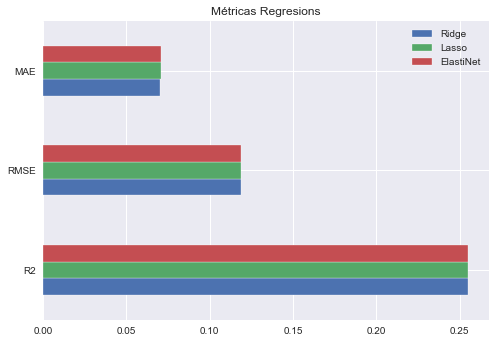

In [68]:
# Se comparan las métricas de cada modelo
data = { 'Ridge': [r2_score(y_test,model_ridge.predict(X_test)).round(3), 
                                    np.sqrt(mean_squared_error(y_test,model_ridge.predict(X_test))).round(3),
                                    median_absolute_error(y_test,model_ridge.predict(X_test)).round(3)],
         'Lasso': [r2_score(y_test,model_lasso.predict(X_test)).round(3), 
                                    np.sqrt(mean_squared_error(y_test,model_lasso.predict(X_test))).round(3),
                                    median_absolute_error(y_test,model_lasso.predict(X_test)).round(3)],
        'ElastiNet': [r2_score(y_test,model_elastic_net.predict(X_test)).round(3), 
                                    np.sqrt(mean_squared_error(y_test,model_elastic_net.predict(X_test))).round(3),
                                    median_absolute_error(y_test,model_elastic_net.predict(X_test)).round(3)]
       }
errors_df = pd.DataFrame(data, index=['R2','RMSE','MAE'])
display(errors_df.head())
display(errors_df.plot(title='Métricas Regresions',kind='barh'))

- Si comparamos los tres modelos, son practicamente iguales los resultados, es decir no hay diferencias entre los r2 y los errores de la media y error absoluto, la diferencia se encuentra en los lambda y en las penalizaciones, por ejemplo lasso y elastic net eliminan la variable 'density' del modelo. el Lambda de Ridge es 10, el Lambda de Lasso es 0.0005 y el de ElasticNet es 0.001

In [31]:
names_regressors

Index(['fixed_acidity', 'volatile acidity', 'citric_acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [32]:
data = { 'ridge': model_ridge.coef_, 'lasso': model_lasso.coef_, 'elastic': model_elastic_net.coef_ }
coefs_data = pd.DataFrame(data, index=X.columns)
coefs_data


,ridge,lasso,elastic
fixed_acidity,0.006493,0.005522,0.005505
volatile acidity,-0.039966,-0.039585,-0.039555
citric_acid,-0.009999,-0.008373,-0.008323
residual sugar,0.003394,0.002793,0.002791
chlorides,-0.011436,-0.010956,-0.010960
free sulfur dioxide,0.006416,0.005414,0.005412
total sulfur dioxide,-0.014259,-0.013207,-0.013208
density,-0.000092,0.000000,0.000000
pH,-0.012911,-0.012256,-0.012236
sulphates,0.029349,0.028836,0.028826


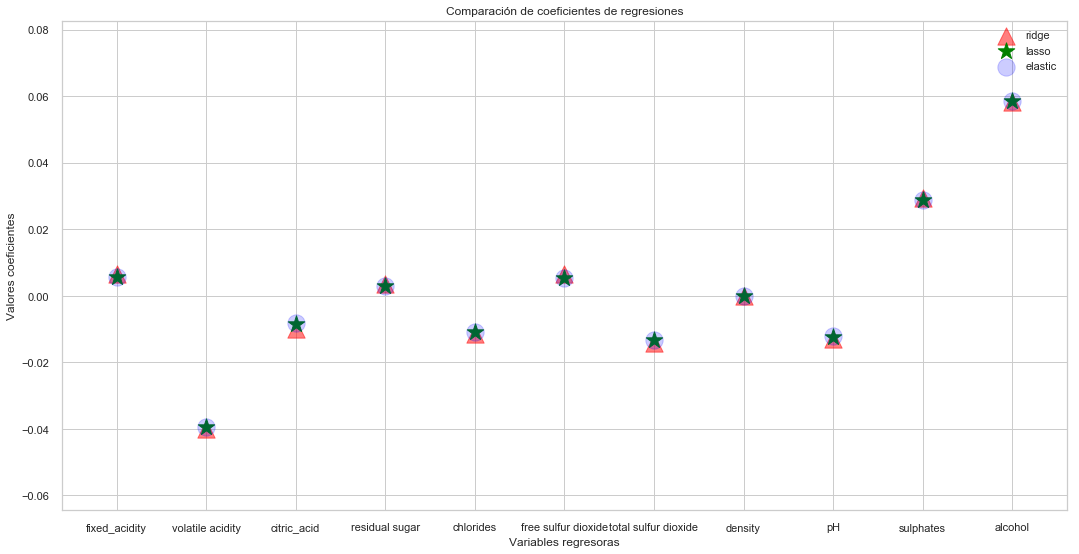

In [62]:
names= list(coefs_data.index)
plt.figure(figsize=(18, 9))

plt.scatter(names, coefs_data['ridge'], 
            c='red', alpha= 0.5,  marker='^', s= 300, label='ridge')

plt.scatter(names, coefs_data['lasso'], 
            c='green',marker='*',s= 300, label='lasso')

plt.scatter(names, coefs_data['elastic'], 
            c='blue', alpha= 0.2,s= 300, label='elastic')

mpl.rcParams['font.size'] = 18
plt.title('Comparación de coeficientes de regresiones')
plt.xlabel('Variables regresoras')
plt.ylabel('Valores coeficientes')
plt.legend(loc='best')
plt.show()
 

- En terminos generales, los tres modelos tienen un desempeño similar, según lo observado, las diferencias entre los atributos no son demasiado significativas, salvo que Lasso y ElasticNet eliminan la variable Density del modelo.  En terminos generales, se muestra como  las variables influencian en la variable objetivo "quality" por ejemplo, los sulfatos y el alcohol  tienden a incrementar ligeramente las condiciones de calidad, por el contrario la volatilidad y acidez tienden a disminuir el factor calidad del vino.